# Trabajo Práctico N°2 - Introducción a Inteligencia Artificial | Regresión del valor de valor medio de casas en distritos de California

Este es un [dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) muy popular que vamos a leer desde **Scikit-Learn**.

Se requiere construir un modelo de regresión que nos permita predecir el valor medio de las casas en distintos distritos de California (medido en cientos de miles de dólares, es decir, $100,000). Este conjunto de datos proviene del censo de EE. UU. de 1990, donde cada observación corresponde a un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (típicamente con una población de entre 600 y 3,000 personas).


Un hogar es un grupo de personas que residen dentro de una misma vivienda. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores altos en bloques con pocos hogares y muchas viviendas vacías.

Los atributos, en el orden en que se guardaron en el dataset, son:

- `MedInc`: Ingreso medio del bloque
- `HouseAge`: Edad mediana de las viviendas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar
- `AveBedrms`: Número promedio de dormitorios por hogar
- `Population`: Población del bloque
- `AveOccup`: Número promedio de personas por hogar
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

### Import de librerías y datos 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Lectura del dataset
california_housing = fetch_california_housing()

# Obtenemos los atributos y el target:
X = california_housing.data
y = california_housing.target

# Transformamos los datos a estructuras de Pandas:
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos X e y; esto es útil para generar el mapa de calor de correlaciones
df_california = pd.concat([X, y], axis=1)

### Análisis exploratorio de datos (EDA)

In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [5]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [40]:
df_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


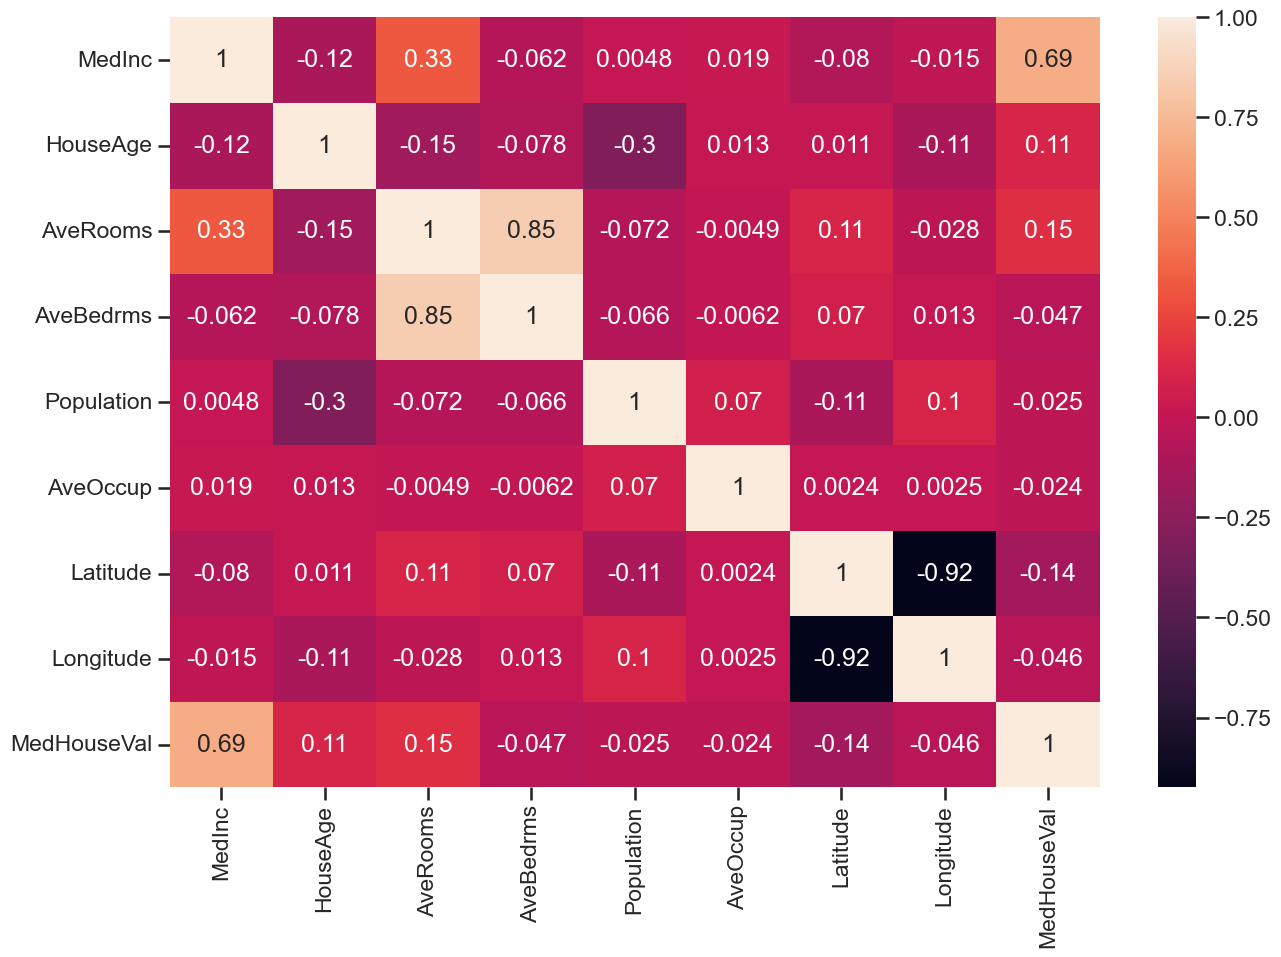

In [7]:
plt.figure(figsize=(15, 10))
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(df_california.corr(),annot=True)
plt.show()

Tomando la matriz de correlación del gráfico, el ranking de correlaciones (en valor absoluto) de mayor a menor nos queda:

| #  | Atributo 1 | Atributo 2  | Correlación |
| -- | ---------- | ----------- | ----------- |
| 1  | Latitude   | Longitude   | **-0.92**   |
| 2  | AveRooms   | AveBedrms   | **0.85**    |
| 3  | MedInc     | MedHouseVal | **0.69**    |
| 4  | Population | HouseAge    | **-0.30**   |
| 5  | AveRooms   | MedInc      | **0.33**    |
| 6  | HouseAge   | AveRooms    | **-0.15**   |
| 7  | HouseAge   | AveBedrms   | **-0.078**  |
| 8  | Latitude   | MedHouseVal | **-0.14**   |
| 9  | HouseAge   | MedHouseVal | **0.11**    |
| 10 | AveRooms   | MedHouseVal | **0.15**    |
| 11 | AveBedrms  | Latitude    | **0.07**    |
| 12 | AveBedrms  | MedHouseVal | **-0.047**  |
| 13 | AveRooms   | Latitude    | **0.11**    |
| 14 | Longitude  | MedHouseVal | **-0.046**  |
| 15 | Longitude  | Population  | **0.10**    |
| 16 | Population | Latitude    | **-0.11**   |
| 17 | HouseAge   | Longitude   | **-0.11**   |
| 18 | Population | MedHouseVal | **-0.025**  |
| 19 | AveOccup   | Population  | **0.07**    |
| 20 | AveOccup   | Longitude   | **0.0025**  |

Así los pares de atributos con mayor correlación (en valor absoluto) son:

- AveRooms y AveBedrms → 0.85 (correlación positiva muy alta).

- Latitude y Longitude → -0.92 (correlación negativa muy alta, aunque aquí la relación es geográfica y no causal).

- MedInc y MedHouseVal → 0.69 (correlación positiva fuerte).

Si consideramos solo relaciones entre características no triviales (sin contar ubicación geográfica), el par AveRooms – AveBedrms es el más fuertemente correlacionado.

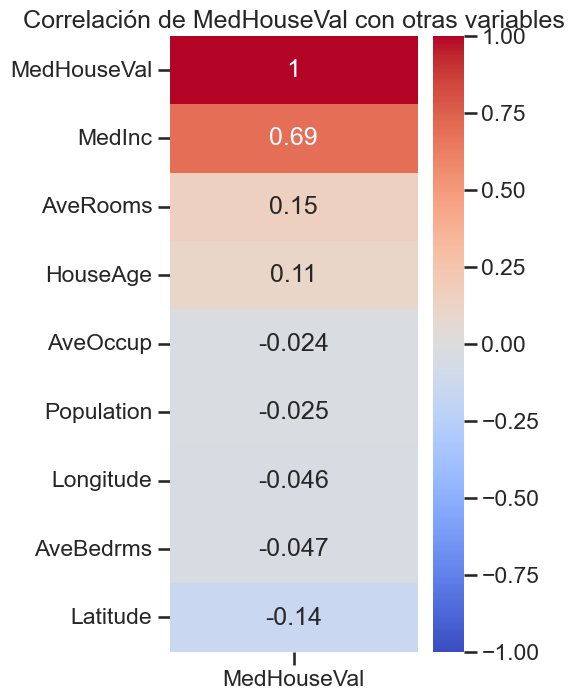

In [8]:
feature = "MedHouseVal"

corr = df_california.corr()[[feature]].sort_values(by=feature, ascending=False)

plt.figure(figsize=(4, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title(f"Correlación de {feature} con otras variables")
plt.show()

Las features mas corelacionadas con el target son: MedInc; AveRooms; y Latitude. 

<Figure size 1500x1000 with 0 Axes>

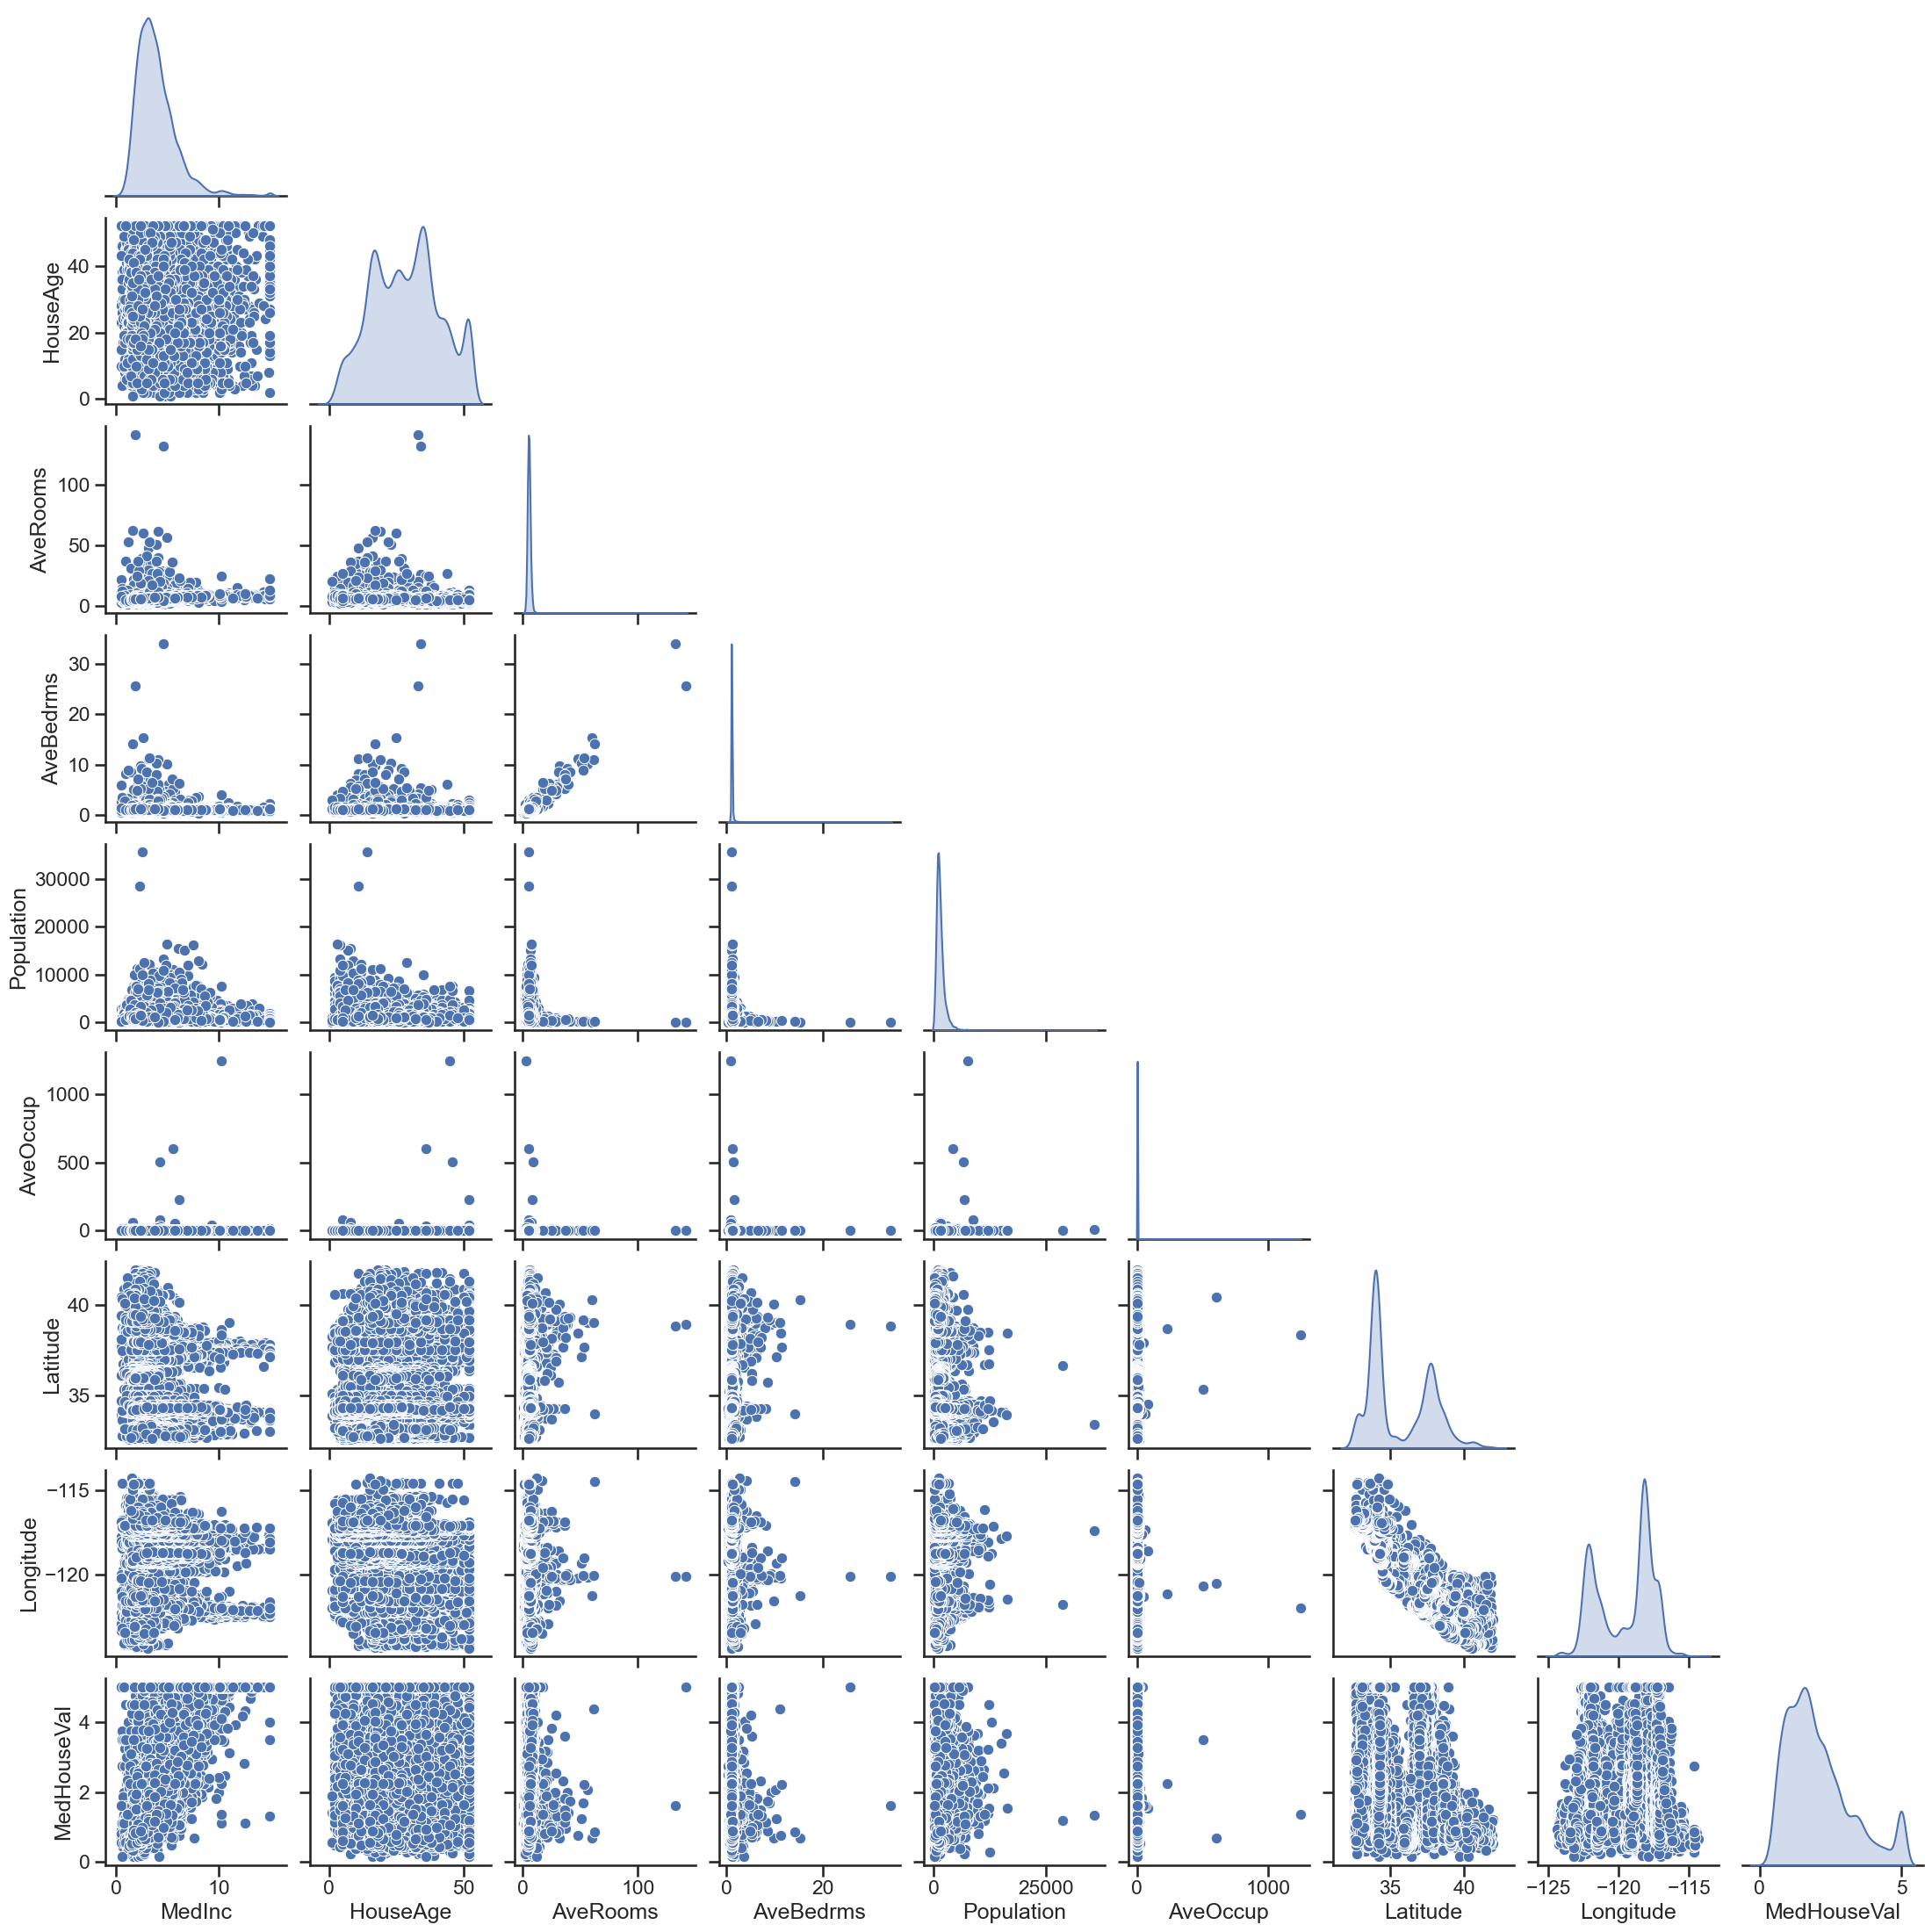

In [10]:
# pairplot para correlación entre variables y target
plt.figure(figsize=(15, 10))
sns.pairplot(data=df_california, diag_kind='kde', corner=True)
plt.show()


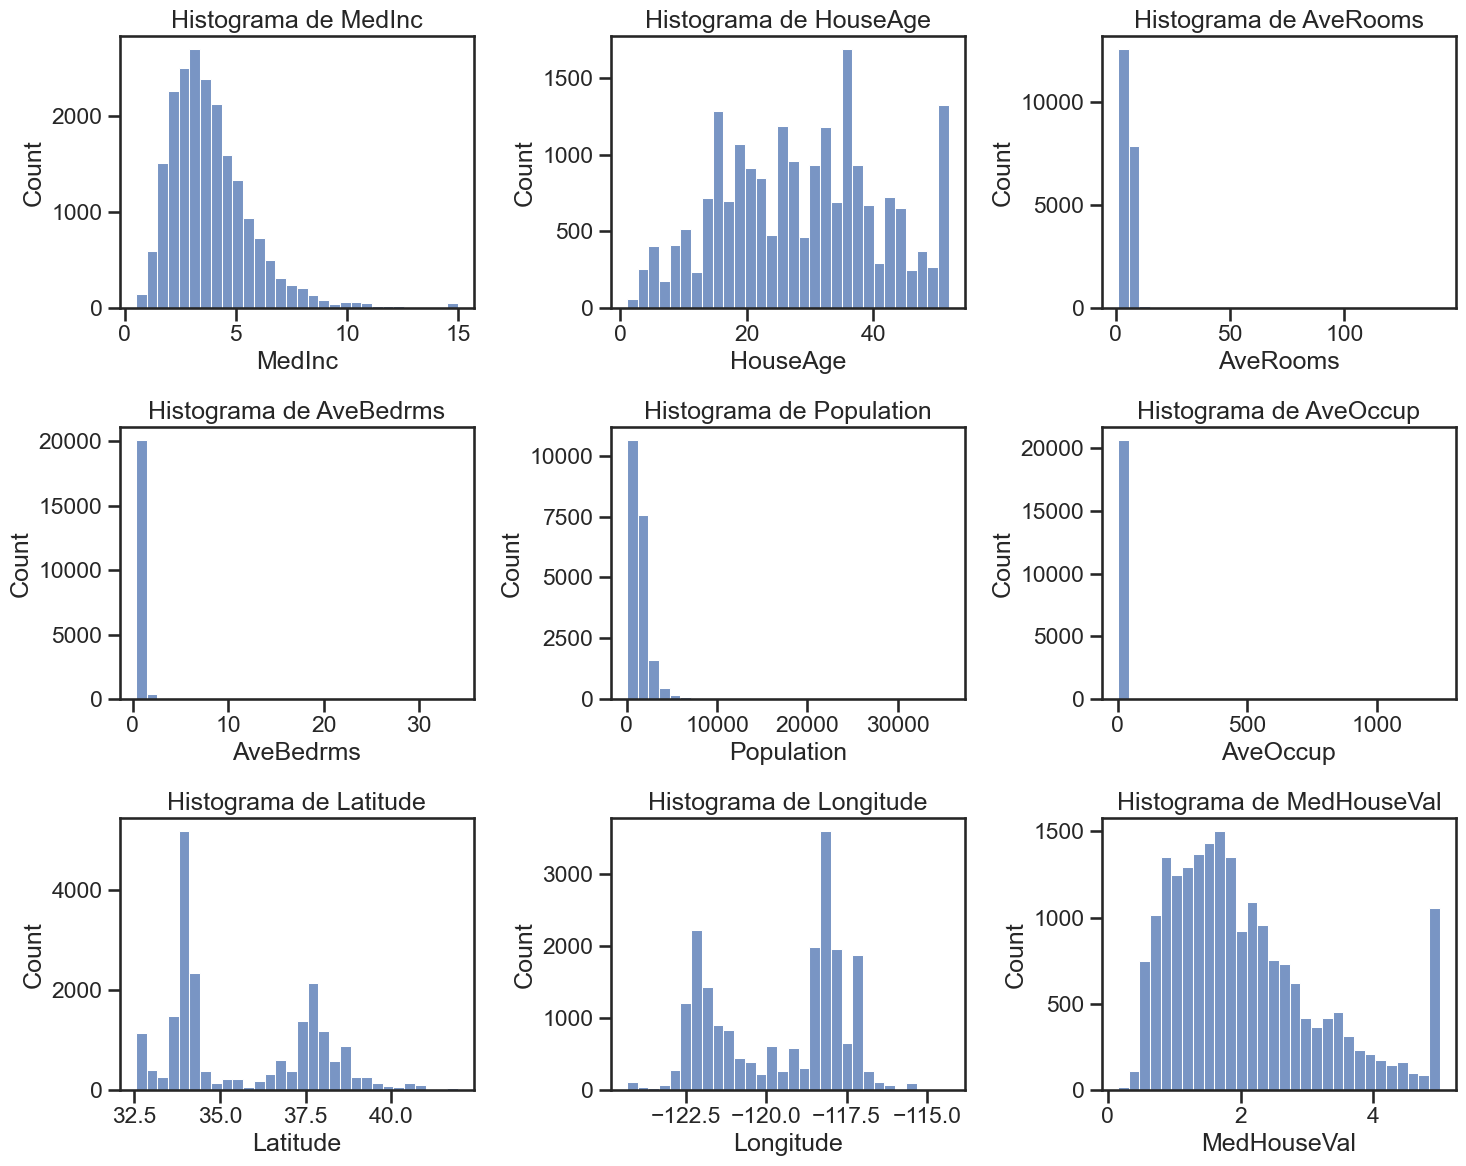

In [11]:
# Grafico de histograma de features numéricas
num_cols = df_california.select_dtypes(include='number').columns
n_cols = 3  # cantidad de columnas en la grilla
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_california[col], bins=30, ax=axes[i], kde=False)
    axes[i].set_title(f'Histograma de {col}')

# Sacar ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

House age parece distribuirse aproximadamente como una distribución normal; por otro lado MedInc y MEdHouseVal parecen tener una distribución sesgada a la derecha, con la particularidad de MedHouseVal de tener alta cantidad de valores en el rango superior, que va a mover la media considerablemente y probablemente afecte el resultado de la regresión 

### División en entrenamiento y evaluación; normalización 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

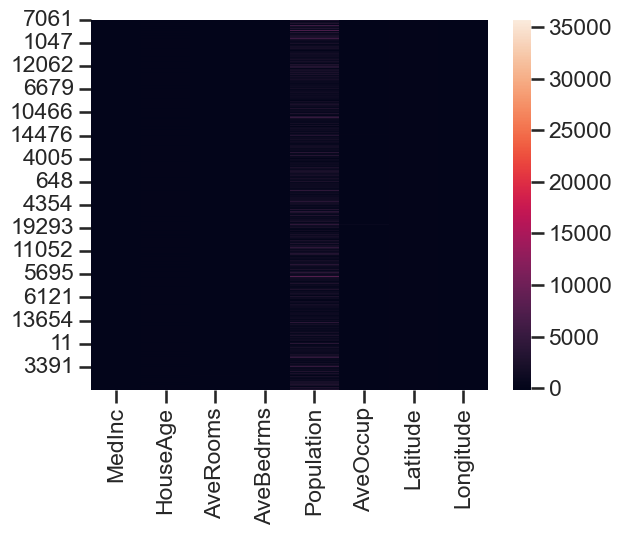

In [14]:
# realizamos un heatmap sobre la matriz X resultante, population esta fuera de escala. 
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(X_train)
plt.show()

In [15]:
# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

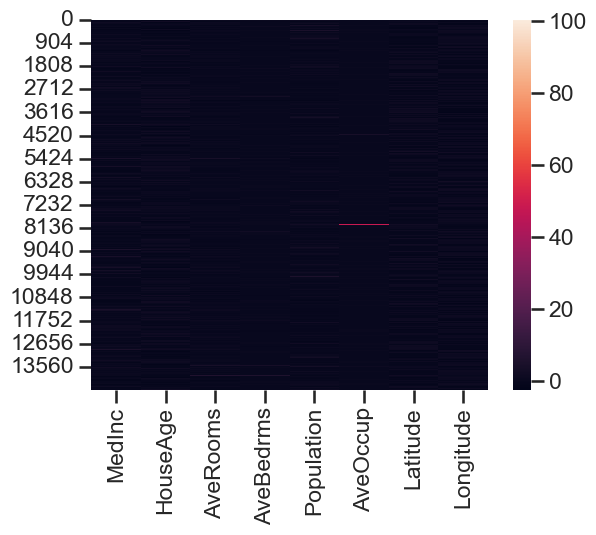

In [16]:
# realizamos un heatmap sobre la matriz X resultante, datos mas escalados ahora
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(X_train_scaled)
plt.show()

### Modelos: Regresión Lineal y Ridge (con búsqueda de hiperparametro)

In [17]:
# Seteamos modelo inicial de regresión 

Linear = LinearRegression()
Linear.fit(X_train_scaled, y_train)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = cross_validate(Linear, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=False)

print("R2 scores:", scores['test_r2'])
print("MSE scores:", -scores['test_neg_mean_squared_error'])
print("MAE scores:", -scores['test_neg_mean_absolute_error'])

print("\nPromedios:")
print("R2 promedio:", np.mean(scores['test_r2']))
print("MSE promedio:", -np.mean(scores['test_neg_mean_squared_error']))
print("MAE promedio:", -np.mean(scores['test_neg_mean_absolute_error']))

R2 scores: [0.60488715 0.6034532  0.61703246 0.61092899 0.59661709]
MSE scores: [0.54787556 0.500835   0.52045639 0.51612252 0.54883741]
MAE scores: [0.54382663 0.52543174 0.52276044 0.52805288 0.5393325 ]

Promedios:
R2 promedio: 0.6065837773699929
MSE promedio: 0.5268253746355749
MAE promedio: 0.5318808372496995


In [18]:
# Resultados para ejercicio n°3 

y_pred_train = Linear.predict(X_train_scaled)

TSS = ((y_train - y_train.mean())**2).sum() #TSS total sum of squares
RSS = ((y_train - y_pred_train)**2).sum() #RSS residual sum of squares
ESS = ((y_pred_train - y_train.mean())**2).sum() # ESS explained sum of squares

r2_linear = ESS / TSS  # o 1 - RSS / TSS

print("\nComparación de varianza:")
print(f"Varianza total de los datos (TSS): {TSS}")
print(f"Varianza residual (RSS): {RSS}")
print(f"Varianza explicada por el modelo (ESS): {ESS}")
print(f"Coeficiente de determinación (R^2): {r2_linear:.4f}")



Comparación de varianza:
Varianza total de los datos (TSS): 19355.92748251429
Varianza residual (RSS): 7561.471021289252
Varianza explicada por el modelo (ESS): 11794.456461225076
Coeficiente de determinación (R^2): 0.6093


In [19]:
# Rango de alpha
alpha_range = np.linspace(0.01, 12.5, 50)  # 50 valores entre 0.01 y 12.5

# Modelo Ridge
ridge = Ridge()

# Definir scoring (MSE negativo porque sklearn maximiza la métrica)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearch con CV de 5 folds
param_grid = {'alpha': alpha_range}
grid = GridSearchCV(ridge, param_grid, cv=5, scoring=scorer)
grid.fit(X_train_scaled, y_train)

# Extraer resultados
mean_scores_ridge = -grid.cv_results_['mean_test_score']  # convertir a positivo
best_alpha = grid.best_params_['alpha']

print(f"Mejor alpha: {best_alpha}")
print(f"MSE promedio con mejor alpha: {mean_scores_ridge[grid.best_index_]}")

best_ridge = grid.best_estimator_

Mejor alpha: 6.63734693877551
MSE promedio con mejor alpha: 0.5268175785432091


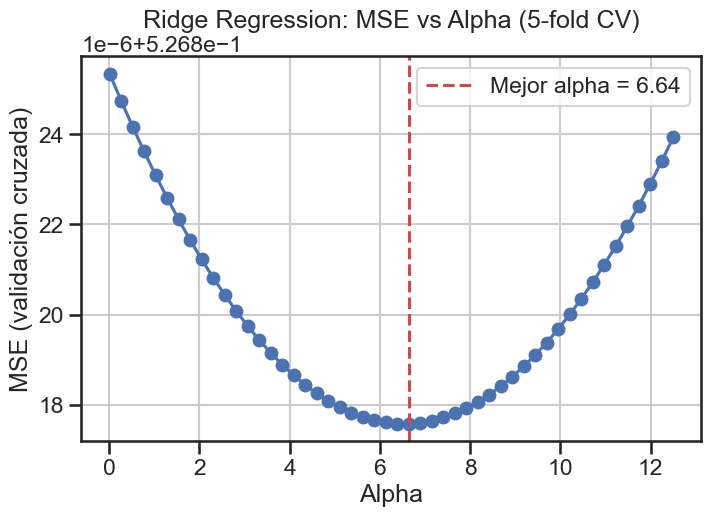

In [20]:
# Graficar MSE vs alpha
plt.figure(figsize=(8,5))
plt.plot(alpha_range, mean_scores_ridge, marker='o')
plt.xlabel("Alpha")
plt.ylabel("MSE (validación cruzada)")
plt.title("Ridge Regression: MSE vs Alpha (5-fold CV)")
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Mejor alpha = {best_alpha:.2f}')
plt.legend()
plt.grid(True)
plt.show()

### Resultados y conclusiones TP

#### Ejecución de modelos

In [21]:
# Validacion de resultados contra validation set 

# Baseline

baseline = y_train.mean()
y_pred_baseline = np.full(len(y_test), baseline)

r2_score_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)

print("\nResultados para Baseline (media):")
print("R²:", r2_score_baseline)
print("MSE:", mse_baseline)
print("MAE:", mae_baseline)


Resultados para Baseline (media):
R²: -3.930972139576383e-06
MSE: 1.3125452673724591
MAE: 0.906200749174264


In [22]:
# Validacion de resultados contra validation set 

# Linear

y_pred_linear = Linear.predict(X_test_scaled)

r2_score_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)

variance_linear = np.var(y_test - y_pred_linear)

print("\nResultados para regresión lineal:")
print("R²:", r2_score_linear)
print("MSE:", mse_linear)
print("MAE:", mae_linear)



Resultados para regresión lineal:
R²: 0.5957702326061665
MSE: 0.5305677824766752
MAE: 0.5272474538305951


In [23]:
# Validacion de resultados contra validation set 

# Ridge

y_pred_ridge = best_ridge.predict(X_test_scaled)

r2_score_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("\nResultados para regresión Ridge:")
print("R²:", r2_score_ridge)
print("MSE:", mse_ridge)
print("MAE:", mae_ridge)



Resultados para regresión Ridge:
R²: 0.5958879163877131
MSE: 0.5304133177933559
MAE: 0.5272214904045512


#### Resultados 

In [24]:
# Ejercicio n°3: comparación de resultados de varianza de modelo vs datos. 
print("\nComparación de varianza")
print("Varianza de los datos:", np.var(y_test))
print("Varianza del modelo lineal:", variance_linear)
print("Coeficiente de Pearson (R2) para la regresión lineal:", r2_score_linear)



Comparación de varianza
Varianza de los datos: 1.3125401078138632
Varianza del modelo lineal: 0.530566187141439
Coeficiente de Pearson (R2) para la regresión lineal: 0.5957702326061665


In [25]:

# Formulación de tabla comparativa de resultados

results = {
    'Model': ['Baseline', 'Linear Regression', f'Ridge (α={best_alpha:.2f})'],
    'R²': [
        r2_score_baseline,
        r2_score_linear,
        r2_score_ridge
    ],
    'MSE': [
        mse_baseline,
        mse_linear,
        mse_ridge
    ],
    'MAE': [
        mae_baseline,
        mae_linear,
        mae_ridge
    ]
}

# Crear DataFrame
df_results = pd.DataFrame(results)

# Mostrar tabla con formato
styled = (
    df_results.style
    .format({'R²': '{:.4f}', 'MSE': '{:.4f}', 'MAE': '{:.4f}'})
    .set_properties(**{'text-align': 'center'})
)

styled

,Model,R²,MSE,MAE
0,Baseline,-0.0000,1.3125,0.9062
1,Linear Regression,0.5958,0.5306,0.5272
2,Ridge (α=6.64),0.5959,0.5304,0.5272


In [26]:
# Resultados son bastante mediocres, se podría intentar retirar outliers de MedHouseVal

### Propuesta de mejora de modelo 


In [27]:
# datos de medhouseval 
df_california['MedHouseVal'].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

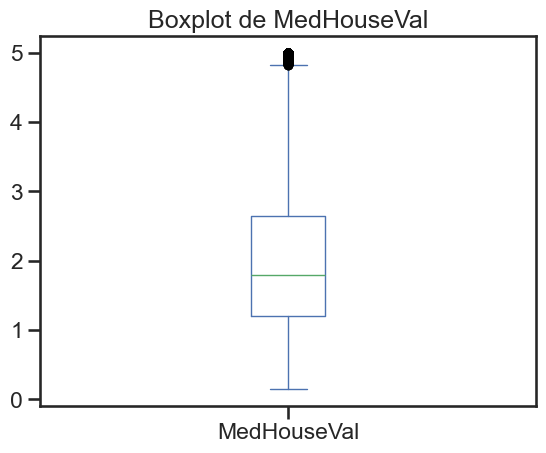

In [28]:
df_california["MedHouseVal"].plot(kind="box")
plt.title("Boxplot de MedHouseVal")
plt.show()

In [29]:
# Separación de outliers 
col = df_california["MedHouseVal"]
Q1 = col.quantile(0.25)
Q3 = col.quantile(0.75)
IQR = Q3 - Q1

#limites
limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

df_california_filtrada = df_california[(col >= limite_inferior) & (col <= limite_superior)]

In [30]:
print("Cantidad con outliers:", len(df_california))
print("Cantidad sin outliers:", len(df_california_filtrada))

Cantidad con outliers: 20640
Cantidad sin outliers: 19569


In [31]:
X_new = df_california_filtrada.drop(columns=['MedHouseVal'])
y_new = df_california_filtrada['MedHouseVal']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_new,  y_new, test_size=0.3, random_state=42)

In [33]:
# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

In [34]:
# Seteamos modelo inicial de regresión 

Linear = LinearRegression()
Linear.fit(X_train_scaled, y_train)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = cross_validate(Linear, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=False)

print("R2 scores:", scores['test_r2'])
print("MSE scores:", -scores['test_neg_mean_squared_error'])
print("MAE scores:", -scores['test_neg_mean_absolute_error'])

print("\nPromedios:")
print("R2 promedio:", np.mean(scores['test_r2']))
print("MSE promedio:", -np.mean(scores['test_neg_mean_squared_error']))
print("MAE promedio:", -np.mean(scores['test_neg_mean_absolute_error']))

R2 scores: [0.56332101 0.57458184 0.54806299 0.54597266 0.5686112 ]
MSE scores: [0.40916246 0.37498503 0.41231883 0.40545285 0.39776247]
MAE scores: [0.48265059 0.46656965 0.47239999 0.47782531 0.46557351]

Promedios:
R2 promedio: 0.5601099392457756
MSE promedio: 0.39993632691388714
MAE promedio: 0.4730038101776195


In [35]:
# Rango de alpha
alpha_range = np.linspace(0.01, 12.5, 50)  # 50 valores entre 0.01 y 12.5

# Modelo Ridge
ridge = Ridge()

# Definir scoring (MSE negativo porque sklearn maximiza la métrica)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearch con CV de 5 folds
param_grid = {'alpha': alpha_range}
grid = GridSearchCV(ridge, param_grid, cv=5, scoring=scorer)
grid.fit(X_train_scaled, y_train)

# Extraer resultados
mean_scores_ridge = -grid.cv_results_['mean_test_score']  # convertir a positivo
best_alpha_2 = grid.best_params_['alpha']

print(f"Mejor alpha: {best_alpha_2}")
print(f"MSE promedio con mejor alpha: {mean_scores_ridge[grid.best_index_]}")

best_ridge = grid.best_estimator_

Mejor alpha: 12.5
MSE promedio con mejor alpha: 0.39987878935378707


In [36]:
# Validacion de resultados contra validation set 

# Linear

y_pred_linear = Linear.predict(X_test_scaled)

r2_score_linear_2 = r2_score(y_test, y_pred_linear)
mae_linear_2 = mean_absolute_error(y_test, y_pred_linear)
mse_linear_2 = mean_squared_error(y_test, y_pred_linear)


In [37]:
# Validacion de resultados contra validation set 

# Ridge

y_pred_ridge = best_ridge.predict(X_test_scaled)

r2_score_ridge_2 = r2_score(y_test, y_pred_ridge)
mae_ridge_2 = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge_2 = mean_squared_error(y_test, y_pred_ridge)


In [38]:

# Formulación de tabla comparativa de resultados

results = {
    'Model': ['Baseline', 'Linear Regression', f'Ridge (α={best_alpha:.2f})', 'Linear Regression (Outliers Removed)', f'Ridge (Outliers removed, α={best_alpha_2:.2f})'],
    'R²': [
        r2_score_baseline,
        r2_score_linear,
        r2_score_ridge,
        r2_score_linear_2,
        r2_score_ridge_2
    ],
    'MSE': [
        mse_baseline,
        mse_linear,
        mse_ridge,
        mse_linear_2,
        mse_ridge_2
    ],
    'MAE': [
        mae_baseline,
        mae_linear,
        mae_ridge,
        mae_linear_2,
        mae_ridge_2
    ]
}

# Crear DataFrame
df_results = pd.DataFrame(results)

# Mostrar tabla con formato
styled = (
    df_results.style
    .format({'R²': '{:.4f}', 'MSE': '{:.4f}', 'MAE': '{:.4f}'})
    .set_properties(**{'text-align': 'center'})
)

styled

,Model,R²,MSE,MAE
0,Baseline,-0.0000,1.3125,0.9062
1,Linear Regression,0.5958,0.5306,0.5272
2,Ridge (α=6.64),0.5959,0.5304,0.5272
3,Linear Regression (Outliers Removed),0.5953,0.3697,0.4603
4,"Ridge (Outliers removed, α=12.50)",0.5952,0.3698,0.4603


Modelo mejora 0.06 en R2 y reduce MSE en alrededor de 0.2, asi como 0.06 en MAE.